## Pytorch basics
- torch.full 
- torch.tensor
- torch.empty

In [7]:
import torch
x=torch.tensor([[1, 2., 3],
                [4, 5, 6],
                [7, 8., 9],
                [10, 11, 12]])
x
x.view(3,-1)
print(x)
z = torch.empty(3,4)
print(z)
z

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [27]:
import torch
class TensorOperation:
    def __init__(self):
        self.a = torch.tensor([1., 2., 3.])
        self.b = torch.tensor([10., 20., 30.])
        self.c= torch. tensor([100., 200., 300.])
    def create_tensor_operation(self):
        self.a.requires_grad=True 
        self.b.requires_grad=True
        a_inter = self.a.pow(2).sum()
        b_inter = self.b.log().sum()
        d =  a_inter + b_inter 
        print(d)
        return d
#print(d.backward())

## autograd
- use of the torch.autograd 
  - it will internally calculate the gradients and calls the .backward method
  - an internal context manager that disables gradient tracking(useful during the evaluation or inference)
- torch.backward
  - computes gradients for the tensors for which requires_grad=True
  - 
- concept of the leaf and non-leaf tensor.


### **1. `requires_grad` and Gradient Storage**
- PyTorch only stores gradients (`.grad`) for tensors that have `requires_grad=True`.
- The scalar `d` (result of `a_inter + b_inter`) **does not require gradients**, because it is not an input tensor but an **intermediate output** derived from operations involving `a` and `b`.

In contrast, `a` and `b` explicitly have `requires_grad=True`, signaling PyTorch to track their contributions to the loss and store their gradients after backpropagation.

---

### **2. What Happens During `d.backward()`**
When you call `d.backward()`:
- PyTorch computes the gradient of `d` (the scalar) **with respect to each input tensor** (`a` and `b`), because these tensors are the ones with `requires_grad=True`.
- The gradients are stored in `a.grad` and `b.grad`, as they are the parameters that PyTorch assumes you will optimize (e.g., in gradient descent).

The scalar `d` itself does not need gradients because:
- It is typically used as a **loss function** or intermediate result.
- There is no meaningful operation involving "gradients of `d` with respect to another scalar."

---

### **3. Why Doesn’t `d` Store `.grad`?**
1. **Scalars Don’t Require Gradients**:
   - Scalars (single values like `d` here) represent the result of an operation, not the starting point for optimization. PyTorch computes the derivatives of scalars with respect to tensors (like `a` and `b`), but it doesn't store `.grad` for scalars themselves.
   - Example:
     ```python
     print(d.grad)  # Will give an error because d is not tracked like a tensor with requires_grad=True
     ```

2. **Intermediate Variables Are Not Retained**:
   - Gradients are only stored for tensors explicitly marked with `requires_grad=True`. Intermediate variables like `d` are ephemeral and do not need `.grad` storage.

3. **Gradient Computation Chain**:
   - Gradients flow **backward** through the computational graph from `d` to `a` and `b`. Since `d` is the end of the graph, its gradient with respect to itself is always \( 1 \), which is trivial and unnecessary to store.

---

### **4. Key Takeaway**
- **Gradients Are Stored in Inputs, Not Outputs**:
  - Gradients flow **back to the inputs (like `a` and `b`)** of the graph because those are the tensors you’re typically optimizing.
  - Intermediate outputs like `d` do not store `.grad` because their role is to propagate gradients, not to be optimized.


In [28]:
tensor = TensorOperation()
d=tensor.create_tensor_operation()
d.backward(retain_graph=True)
#print(d.grad)
print(tensor.a.grad,tensor.b.grad)

tensor(22.6995, grad_fn=<AddBackward0>)
tensor([2., 4., 6.]) tensor([0.1000, 0.0500, 0.0333])


In [ ]:
# let us use the above code for a similar task related to torch.autograd instead of the tensor.backward operation.
tensor1 = TensorOperation()
z = tensor1.create_tensor_operation()
op = torch.autograd.grad(z,[tensor1.a,tensor1.b])
print(op) #results in a tuple first element is the grad wrt a and second elem is grad wrt b.

# what if i have more than 2 , let's say 3 tensors in the input list how the output will come after differentiation

tensor(22.6995, grad_fn=<AddBackward0>)
(tensor([2., 4., 6.], grad_fn=<MulBackward0>), tensor([0.1000, 0.0500, 0.0333], grad_fn=<DivBackward0>))


In [54]:
f = tensor1.a.pow(2).sum() + tensor1.b.log().sum()
g = tensor1.a.pow(2).sum() + tensor1.b.log().sum()
print(torch.autograd.grad([f,g],tensor1.a,retain_graph=True)) 
# the gradients are added from both the results first f and second g.
print(torch.autograd.grad(f,tensor1.a))
print(torch.autograd.grad(g,tensor1.a))

(tensor([ 4.,  8., 12.]),)
(tensor([2., 4., 6.]),)
(tensor([2., 4., 6.]),)


- difference b/w the retain graph and create_graph in pytorch.
- Why Use create_graph=True?
  - By default, PyTorch clears the computational graph after gradients are computed (to save memory). However, higher-order derivatives need the graph to remain intact to compute derivatives of derivatives.
  - create_graph=True ensures that the computational graph for the first derivative is retained.

## Comparison

The difference between `create_graph` and `retain_graph` in PyTorch lies in their roles during gradient computation and the handling of computational graphs. Let’s break it down:

---

### **1. `retain_graph`**
- **Purpose**: It determines whether the computational graph used for backpropagation is retained (kept intact) after gradient computation.
- **Default Behavior**: By default, PyTorch frees the graph after computing gradients to save memory. If you need to compute gradients again using the same graph, you must set `retain_graph=True`.
- **Usage**:
  - Retain the graph to reuse it for further computations:
    ```python
    import torch

    x = torch.tensor(2.0, requires_grad=True)
    y = x**2

    # First backward pass with retain_graph=True
    y.backward(retain_graph=True)
    print(x.grad)  # Output: 4.0

    # Second backward pass (graph retained from the previous pass)
    y.backward()  # Works because the graph was retained
    print(x.grad)  # Output: 8.0 (gradients accumulate by default)
    ```

- **When to Use**:
  - You need to perform multiple backward passes using the same graph (e.g., for gradient penalties or higher-order derivatives).
  
---

### **2. `create_graph`**
- **Purpose**: It enables the creation of a computational graph for higher-order derivatives.
- **Default Behavior**: When computing first-order derivatives, the graph is not created for the gradients themselves. If you need higher-order derivatives, you must set `create_graph=True`.
- **Usage**:
  - Create a graph for higher-order gradient computation:
    ```python
    x = torch.tensor(2.0, requires_grad=True)
    y = x**3

    # Compute the first derivative with create_graph=True
    grad_1 = torch.autograd.grad(y, x, create_graph=True)  # Retain the graph for higher-order gradients
    print(grad_1[0])  # Output: 12.0 (first derivative)

    # Compute the second derivative
    grad_2 = torch.autograd.grad(grad_1[0], x)  # Higher-order gradient computation
    print(grad_2[0])  # Output: 6.0 (second derivative)
    ```

- **When to Use**:
  - You need higher-order derivatives, such as second derivatives or gradient penalties in advanced optimization tasks.

---

### **Key Differences**
| Feature                      | `retain_graph`                     | `create_graph`                     |
|-------------------------------|-------------------------------------|-------------------------------------|
| **Purpose**                  | Retain the graph for reuse         | Enable the creation of a graph for higher-order gradients |
| **Default Behavior**         | Graph is freed after backward      | No graph created for gradients themselves |
| **Use Case**                 | Reusing the graph for multiple backward passes | Computing higher-order derivatives |
| **Impact on Memory**         | Increased memory usage for storing the graph | Additional memory usage for creating gradient graphs |

---

### **Practical Summary**
- Use `retain_graph=True` for reusing the computational graph multiple times within the same session.
- Use `create_graph=True` for higher-order derivatives where gradients themselves need to be differentiated.


In [57]:
# computing the higher order derivatives can be done using the 
x = torch.tensor(10.,requires_grad=True)
y = x**3
result = torch.autograd.grad(y,x,create_graph=True) # results in a tuple
#print(type(result)) # tuple
print(result,x.grad,result[0]) # the .grad doesn't stores information wrt to the autograd in pytorch.
second_result= torch.autograd.grad(result[0],x)
print(second_result,second_result[0])

(tensor(300., grad_fn=<MulBackward0>),) None tensor(300., grad_fn=<MulBackward0>)
(tensor(60.),) tensor(60.)


## Use of the torch.no_grad 

# Gradient Descent Application

# given below function the idea is to apply the gradient descent algorithm 
    - first plot the graph for this function, how can i do that?

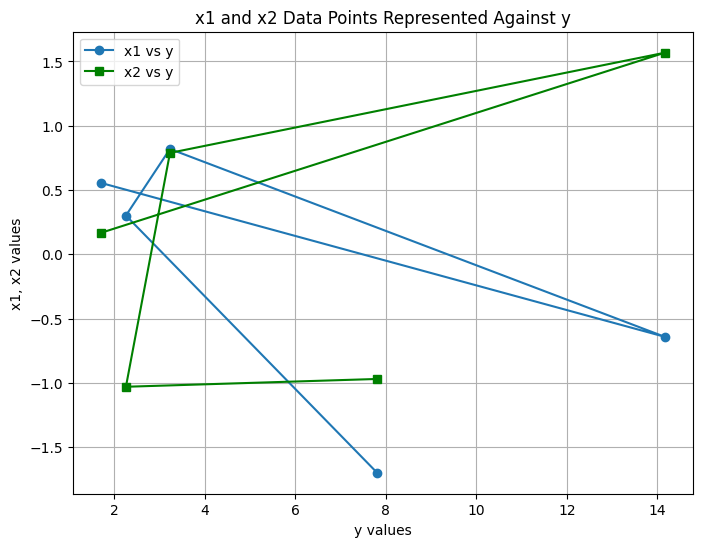

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def f(a, b):
    return (a - 1.0)**2 + (b + 1.)**2 + (a-b)**2

x2_datapoints = []
x1_datapoints = []
y_datapoints = []
for _ in enumerate(range(10)):
    x1 = np.random.randn()
    x2 = np.random.randn()
    y = f(x1,x2)
    x1_datapoints.append(x1)
    x2_datapoints.append(x2)
    y_datapoints.append(y)

plt.figure(figsize=(8, 6))
plt.scatter(y_datapoints,x1_datapoints,"o-", label="x1 vs y",alpha=0.7 )
plt.scatter(y_datapoints,x2_datapoints, "s-", label="x2 vs y", color="green",alpha=0.7)
# results.append((x1,x2,y))

# Add labels and legend
plt.xlabel("y values")
plt.ylabel("x1, x2 values")
plt.title("x1 and x2 Data Points Represented Against y")
plt.legend()
plt.grid()
plt.show()
# plt.plot(results)

## Dual Axis chart

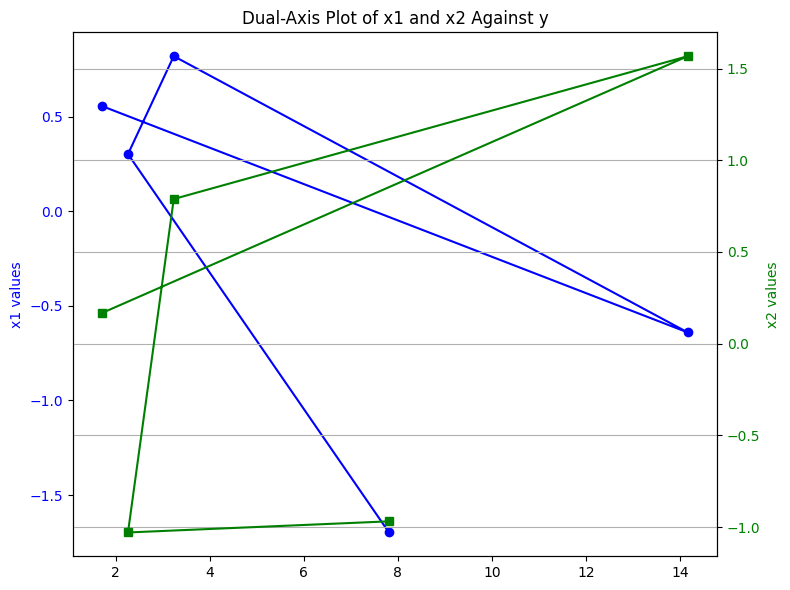

In [70]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# First axis (x1 vs y)
ax1.plot(y_datapoints, x1_datapoints, "o-", label="x1 vs y", color="blue")
ax1.set_ylabel("x1 values", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Second axis (x2 vs y)
ax2 = ax1.twinx()
ax2.plot(y_datapoints, x2_datapoints, "s-", label="x2 vs y", color="green")
ax2.set_ylabel("x2 values", color="green")
ax2.tick_params(axis='y', labelcolor="green")

# Add labels and title
plt.xlabel("y values")
plt.title("Dual-Axis Plot of x1 and x2 Against y")
fig.tight_layout()
plt.grid()
plt.show()
